<a href="https://colab.research.google.com/github/janchorowski/dl_uwr/blob/summer2021/Assignments/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

**Submission deadlines:** 
- get at least 4 points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or lare ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep digmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import time

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

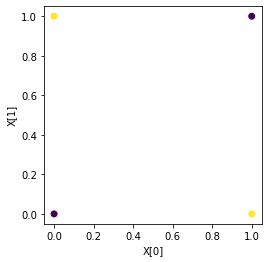

In [2]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [77]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.num_hidden=num_hidden
        self.in_features=in_features
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        odchStd=np.sqrt(0.5)
        self.W1=np.random.randn(self.num_hidden, self.in_features)/odchStd
        self.b1=np.random.randn(self.num_hidden)/odchStd
        self.W2=np.random.randn(1,self.num_hidden)/odchStd
        self.b2=np.random.randn(1)/odchStd

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1               #(N, num_hidden)
        # wyjściem jest N x num_hidden, 
        # a więc pobudzenie każdego neurona z danej warstwy przez kolejne próbki
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)                           #(N, num_hidden)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2              #(N, 1)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)                           #(N, 1)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            N=A2.shape[0]
            A2_grad = O2-Y #O2 = sigmoid(A2)     # (1, 1)
            self.b2_grad = A2_grad.sum(0)/N
            self.W2_grad = A2_grad.T @ O1 / N    #(1, num_hidden)
            O1_grad = A2_grad @ self.W2 #(N, num_hid)
            A1_grad = O1_grad * O1*(1-O1)
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = A1_grad.T @ X /N
        return O2, loss

In [39]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[100,100],[100,100]], dtype=np.float64)
net.b1 = np.array([-150,-50], dtype=np.float64)
net.W2 = np.array([[-200,100]], dtype=np.float64)
net.b2 = np.array([-50], dtype=np.float64)

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=False)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 1.928749847963918e-22
XORnet([0. 1.]) = 1.0
XORnet([1. 0.]) = 1.0
XORnet([1. 1.]) = 7.175095973164411e-66


<ipython-input-32-e8a7f3ae897e>:40: RuntimeWarning: divide by zero encountered in log
  loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
<ipython-input-32-e8a7f3ae897e>:40: RuntimeWarning: invalid value encountered in multiply
  loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)


## Problem 2

In [90]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    print(grad)
    print(orig_grad)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [38]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    print(param_name)
    check_grad(net, param_name, X, Y)

W1
b1
W2
b2


## Problem 3

In [40]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1  # set a learning rate

for i in range(100001):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param[:] = param - alpha * getattr(net, param_name + "_grad")


after 0 steps 	loss=0.7080521136022039
after 5000 steps 	loss=0.0009024650794515715
after 10000 steps 	loss=0.0004254378007708292
after 15000 steps 	loss=0.00027607065552783384
after 20000 steps 	loss=0.0002036295803810344
after 25000 steps 	loss=0.00016100090204573507
after 30000 steps 	loss=0.00013297494631230326
after 35000 steps 	loss=0.00011316950500424894
after 40000 steps 	loss=9.844261569770985e-05
after 45000 steps 	loss=8.706979017494814e-05
after 50000 steps 	loss=7.80265012264411e-05
after 55000 steps 	loss=7.066614715251925e-05
after 60000 steps 	loss=6.456070121227793e-05
after 65000 steps 	loss=5.941565784739715e-05
after 70000 steps 	loss=5.502179679956744e-05
after 75000 steps 	loss=5.1226432514071176e-05
after 80000 steps 	loss=4.7915550111983125e-05
after 85000 steps 	loss=4.500230687329693e-05
after 90000 steps 	loss=4.2419402851165866e-05
after 95000 steps 	loss=4.0113883265275306e-05
after 100000 steps 	loss=3.804351454454452e-05


In [41]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 1.0612550837749812e-05
XORnet([0. 1.]) = 0.9999600859643327
XORnet([1. 0.]) = 0.9999584684862729
XORnet([1. 1.]) = 6.0110864088615105e-05


In [155]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the sucess rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=np.float64)
Y3 = np.array([0,1,1,0,1,0,0,1], dtype=np.float64).reshape((-1,1))

alpha=1

for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNet(3, hidden_dim, dtype=np.float64)
    predictions, loss = net.forward(X3, Y3, do_backward=True)
    t=time.time()
    for i in range(100001):
        _, loss = net.forward(X3, Y3, do_backward=True)
        if (i % 20000) == 0:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    print(f"For {hidden_dim} neurons in hidden layer we got {loss} loss result in {time.time()-t} seconds")

after 0 steps 	loss=1.5718874513693244
after 20000 steps 	loss=0.2818184592687003
after 40000 steps 	loss=0.28147172920812413
after 60000 steps 	loss=0.28135922361580373
after 80000 steps 	loss=0.28129687810937076
after 100000 steps 	loss=0.28118874248478076
For 2 neurons in hidden layer we got 0.28118874248478076 loss result in 11.844173192977905 seconds
after 0 steps 	loss=1.5206986564063634
after 20000 steps 	loss=0.0006560006821578997
after 40000 steps 	loss=0.0003247787308475312
after 60000 steps 	loss=0.0002159153138336793
after 80000 steps 	loss=0.00016174456414663112
after 100000 steps 	loss=0.00012931838619362847
For 3 neurons in hidden layer we got 0.00012931838619362847 loss result in 11.914358377456665 seconds
after 0 steps 	loss=1.1954056548609873
after 20000 steps 	loss=0.000618195179730488
after 40000 steps 	loss=0.0002975091694516104
after 60000 steps 	loss=0.00019517097763605522
after 80000 steps 	loss=0.0001450792652075392
after 100000 steps 	loss=0.000115417269304226

## Problem 4


In [146]:
def relu(x):
    return np.maximum(0,x)


class SmallNetReLu:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.num_hidden=num_hidden
        self.in_features=in_features
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        odchStd=np.sqrt(0.5)
        self.W1=np.random.randn(self.num_hidden, self.in_features)/odchStd
        self.b1=np.random.randn(self.num_hidden)/odchStd
        self.W2=np.random.randn(1,self.num_hidden)/odchStd
        self.b2=np.random.randn(1)/odchStd

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1               #(N, num_hidden)
        # wyjściem jest N x num_hidden, 
        # a więc pobudzenie każdego neurona z danej warstwy przez kolejne próbki
        # Outputs after the sigmoid non-linearity
        O1 = relu(A1)                           #(N, num_hidden)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2              #(N, 1)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)                           #(N, 1)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            N=A2.shape[0]
            A2_grad = O2-Y # (1, 1)
            self.b2_grad = A2_grad.sum(0)/N
            self.W2_grad = A2_grad.T @ O1 / N    #(1, num_hidden)
            O1_grad = A2_grad @ self.W2 #(N, num_hid)
            dO1dA1=np.zeros_like(A1)
            dO1dA1[O1==A1]=1
            A1_grad = O1_grad * dO1dA1
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = A1_grad.T @ X /N
        return O2, loss

In [152]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNetReLu(2, 2, dtype=np.float64)

for param_name in ["W2", "b2", "b1", "W1"]:
    print(param_name)
    check_grad(net, param_name, X, Y)

W2
[[0.         0.23990981]]
[[0.         0.23990981]]
b2
[0.20354752]
[0.20354752]
b1
[0.         0.25273034]
[0.         0.25273034]
W1
[[0.         0.        ]
 [0.06835365 0.06624276]]
[[0.         0.        ]
 [0.06835365 0.06624276]]


In [154]:
X3 = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=np.float64)
Y3 = np.array([0,1,1,0,1,0,0,1], dtype=np.float64).reshape((-1,1))

alpha=1

for hidden_dim in [2, 3, 5, 10, 20]:
    net = SmallNetReLu(3, hidden_dim, dtype=np.float64)
    predictions, loss = net.forward(X3, Y3, do_backward=True)
    t=time.time()
    for i in range(100001):
        _, loss = net.forward(X3, Y3, do_backward=True)
        if (i % 20000) == 0:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    print(f"For {hidden_dim} neurons in hidden layer we got {loss} loss result in {time.time()-t} seconds")

after 0 steps 	loss=0.7919781273088401
after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 2 neurons in hidden layer we got 0.6931471805599453 loss result in 12.550550937652588 seconds
after 0 steps 	loss=0.9575184291545026
after 20000 steps 	loss=0.5411015807024222
after 40000 steps 	loss=0.5411003431839352
after 60000 steps 	loss=0.5410987211470366
after 80000 steps 	loss=0.5410984916158869
after 100000 steps 	loss=0.5410984659742063
For 3 neurons in hidden layer we got 0.5410984659742063 loss result in 12.928548812866211 seconds
after 0 steps 	loss=0.821576967592114
after 20000 steps 	loss=9.33589018011415e-05
after 40000 steps 	loss=4.481030597994773e-05
after 60000 steps 	loss=2.9252624127604318e-05
after 80000 steps 	loss=2.1639086960933636e-05
after 100000 steps 	loss=1.713489956598685e-05
For 5 neurons in hidden 

## Problem 6 (i 5)

In [246]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    return np.maximum(0,x)

class VaNet:
    def __init__(self, in_features, num_hidden, num_hidden_lay, dtype=np.float32, ifSig=True):
        if num_hidden_lay <=1:
            raise RuntimeError("Za malo ukrytych warstw")
        self.num_hidden=num_hidden
        self.in_features=in_features
        self.num_hidden_lay=num_hidden_lay
        self.ifSig=ifSig
        self.init_params()

    def init_params(self):
        odchStd=np.sqrt(0.5)
        self.W=[np.random.randn(self.num_hidden, self.in_features)/odchStd]
        self.b=[np.random.randn(self.num_hidden)/odchStd]
        for i in range(self.num_hidden_lay-1):
            self.W.append(np.random.randn(self.num_hidden, self.num_hidden)/odchStd)
            self.b.append(np.random.randn(self.num_hidden)/odchStd)
        self.W.append(np.random.randn(1,self.num_hidden)/odchStd)
        self.b.append(np.random.randn(1)/odchStd)

    def forward(self, X, Y=None, do_backward=False):
        A = [X @ self.W[0].T + self.b[0]]
        if self.ifSig:
            O = [sigmoid(A[0])]
        else:
            O= [relu(A[0])]
        for i in range(1,len(self.W)-1):
            W=self.W[i]
            b=self.b[i]
            A.append(O[-1]@W.T+b)
            if self.ifSig:
                O.append(sigmoid(A[-1]))
            else:
                O.append(relu(A[-1]))
        A.append(O[-1]@self.W[-1].T+self.b[-1])
        O.append(sigmoid(A[-1]))

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O[-1]) - (1 - Y) * np.log(1.0 - O[-1])
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            N=A[-1].shape[0]
            A_grad = O[-1]-Y
            self.b_grad = [A_grad.sum(0)/N]
            self.W_grad = [A_grad.T @ O[-2] / N]
            for i in range(len(self.W)-1,1,-1):
                O_grad = A_grad @ self.W[i]
                if self.ifSig:
                    A_grad = O_grad * O[i-1]*(1-O[i-1])
                else:
                    dOdA=np.zeros_like(O_grad)
                    dOdA[O[i-1]==A[i-1]]=1
                    A_grad = O_grad * dOdA
                self.b_grad.append(A_grad.mean(0))
                self.W_grad.append(A_grad.T @ O[i-2] /N)
            O_grad = A_grad @ self.W[1]
            if self.ifSig:
                A_grad = O_grad * O[0]*(1-O[0])
            else:
                dOdA=np.zeros_like(O_grad)
                dOdA[O[0]==A[0]]=1
                A_grad = O_grad * dOdA
            self.b_grad.append(A_grad.mean(0))
            self.W_grad.append(A_grad.T @ X /N)
            
            self.b_grad.reverse()
            self.W_grad.reverse()
        return O[-1], loss

In [248]:
def check_grad_va(net, param_name, nr, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)[nr]
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")[nr]
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    #print(grad)
    #print(orig_grad)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [249]:
net = VaNet(2, 2, 2,dtype=np.float64)
for i in range(3):
    for param_name in ["W", "b"]:
        #print(param_name, i)
        check_grad_va(net, param_name, i, X, Y)

net = VaNet(2, 2, 2,dtype=np.float64, ifSig=False)
for i in range(3):
    for param_name in ["W", "b"]:
        #print(param_name, i)
        check_grad_va(net, param_name, i, X, Y)

In [251]:
X3 = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=np.float64)
Y3 = np.array([0,1,1,0,1,0,0,1], dtype=np.float64).reshape((-1,1))

alpha=1

for ifSig in [True, False]:
    for lay in [2,4,6]:
        print("================================")
        for hidden_dim in [2, 3, 5, 10, 20]:
            net = VaNet(3, hidden_dim, lay, dtype=np.float64, ifSig=ifSig)
            predictions, loss = net.forward(X3, Y3, do_backward=True)
            t=time.time()
            for i in range(100001):
                _, loss = net.forward(X3, Y3, do_backward=True)
                if (i % 20000) == 0:
                    print(f"after {i} steps \tloss={loss}")
                for param_name in ["W", "b"]:
                    for nr in range(lay+1):
                        param = getattr(net, param_name)[nr]
                        param[:] = param - alpha * getattr(net, param_name + "_grad")[nr]
            print(f"For {hidden_dim} neurons in hidden layer and {lay} layers we got {loss} loss result in {time.time()-t} seconds")

after 0 steps 	loss=1.0354566571627126
after 20000 steps 	loss=0.5202425331096188
after 40000 steps 	loss=0.5200319540854809
after 60000 steps 	loss=0.5199677374067148
after 80000 steps 	loss=0.5199370512018205
after 100000 steps 	loss=0.5199192847120411
For 2 neurons in hidden layer and 2 layers we got 0.5199192847120411 loss result in 17.86483669281006 seconds
after 0 steps 	loss=0.7021782528938354
after 20000 steps 	loss=0.0006867200732114645
after 40000 steps 	loss=0.00033211782302871066
after 60000 steps 	loss=0.00021903854749362825
after 80000 steps 	loss=0.00016341394155691818
after 100000 steps 	loss=0.00013032556888952564
For 3 neurons in hidden layer and 2 layers we got 0.00013032556888952564 loss result in 18.164801120758057 seconds
after 0 steps 	loss=4.493490652651193
after 20000 steps 	loss=7.927463598900046e-05
after 40000 steps 	loss=3.724649829456868e-05
after 60000 steps 	loss=2.4176564760679e-05
after 80000 steps 	loss=1.7849878238272607e-05
after 100000 steps 	loss=

<ipython-input-246-18b4b4428a58>:45: RuntimeWarning: divide by zero encountered in log
  loss = -Y * np.log(O[-1]) - (1 - Y) * np.log(1.0 - O[-1])
<ipython-input-246-18b4b4428a58>:45: RuntimeWarning: invalid value encountered in multiply
  loss = -Y * np.log(O[-1]) - (1 - Y) * np.log(1.0 - O[-1])


after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 5 neurons in hidden layer and 2 layers we got 0.6931471805599453 loss result in 20.007113218307495 seconds
after 0 steps 	loss=nan
after 20000 steps 	loss=4.400471911297245e-05
after 40000 steps 	loss=2.2658464834619484e-05
after 60000 steps 	loss=1.6022985629444472e-05
after 80000 steps 	loss=1.241406221414754e-05
after 100000 steps 	loss=1.0137161389613599e-05
For 10 neurons in hidden layer and 2 layers we got 1.0137161389613599e-05 loss result in 19.905860662460327 seconds
after 0 steps 	loss=8.487952145759046
after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 20 neurons in hidden layer and 2 layers w

<ipython-input-246-18b4b4428a58>:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 10 neurons in hidden layer and 4 layers we got 0.6931471805599453 loss result in 32.25173497200012 seconds
after 0 steps 	loss=nan
after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 20 neurons in hidden layer and 4 layers we got 0.6931471805599453 loss result in 36.12034320831299 seconds
after 0 steps 	loss=1.902534550732017
after 20000 steps 	loss=0.6931471805599453
after 40000 steps 	loss=0.6931471805599453
after 60000 steps 	loss=0.6931471805599453
after 80000 steps 	loss=0.6931471805599453
after 100000 steps 	loss=0.6931471805599453
For 2 neurons in hidden layer and 6 layers we got 0.6931471805599453

<ipython-input-246-18b4b4428a58>:40: RuntimeWarning: overflow encountered in matmul
  A.append(O[-1]@self.W[-1].T+self.b[-1])
<ipython-input-246-18b4b4428a58>:57: RuntimeWarning: overflow encountered in matmul
  O_grad = A_grad @ self.W[i]
<ipython-input-246-18b4b4428a58>:63: RuntimeWarning: invalid value encountered in multiply
  A_grad = O_grad * dOdA


after 20000 steps 	loss=nan
after 40000 steps 	loss=nan
after 60000 steps 	loss=nan
after 80000 steps 	loss=nan
after 100000 steps 	loss=nan
For 20 neurons in hidden layer and 6 layers we got nan loss result in 51.043829917907715 seconds


## Problem 7

In [252]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


class FBSmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.num_hidden=num_hidden
        self.in_features=in_features
        self.init_params()

    def init_params(self):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        odchStd=np.sqrt(0.5)
        self.W1=np.random.randn(self.num_hidden, self.in_features)/odchStd
        self.b1=np.random.randn(self.num_hidden)/odchStd
        self.W2=np.random.randn(1,self.num_hidden)/odchStd
        self.W2T=np.random.randn(1,self.num_hidden)/odchStd
        self.b2=np.random.randn(1)/odchStd

    def forward(self, X, Y=None, do_backward=False):
        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1               #(N, num_hidden)
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)                           #(N, num_hidden)
        # Inputs to neuron in the second layer
        A2 = O1 @ self.W2.T + self.b2              #(N, 1)
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)                           #(N, 1)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            N=A2.shape[0]
            A2_grad = O2-Y #O2 = sigmoid(A2)     # (1, 1)
            self.b2_grad = A2_grad.sum(0)/N
            self.W2_grad = A2_grad.T @ O1 / N    #(1, num_hidden)
            O1_grad = A2_grad @ self.W2T #(N, num_hid)
            A1_grad = O1_grad * O1*(1-O1)
            self.b1_grad = A1_grad.mean(0)
            self.W1_grad = A1_grad.T @ X /N
        return O2, loss

In [253]:
X3 = np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=np.float64)
Y3 = np.array([0,1,1,0,1,0,0,1], dtype=np.float64).reshape((-1,1))

alpha=1

for hidden_dim in [2, 3, 5, 10, 20]:
    net = FBSmallNet(3, hidden_dim, dtype=np.float64)
    predictions, loss = net.forward(X3, Y3, do_backward=True)
    t=time.time()
    for i in range(100001):
        _, loss = net.forward(X3, Y3, do_backward=True)
        if (i % 20000) == 0:
            print(f"after {i} steps \tloss={loss}")
        for param_name in ["W1", "b1", "W2", "b2"]:
            param = getattr(net, param_name)
            param[:] = param - alpha * getattr(net, param_name + "_grad")
    print(f"For {hidden_dim} neurons in hidden layer we got {loss} loss result in {time.time()-t} seconds")

after 0 steps 	loss=2.1826081334168808
after 20000 steps 	loss=0.5234199296696409
after 40000 steps 	loss=0.5217947641345557
after 60000 steps 	loss=0.5212120709156919
after 80000 steps 	loss=0.5209076866029075
after 100000 steps 	loss=0.5207192242421059
For 2 neurons in hidden layer we got 0.5207192242421059 loss result in 11.34013056755066 seconds
after 0 steps 	loss=1.7429716109985358
after 20000 steps 	loss=0.0008689238661701605
after 40000 steps 	loss=0.0004189292114642601
after 60000 steps 	loss=0.0002745671098647464
after 80000 steps 	loss=0.00020373958574149693
after 100000 steps 	loss=0.00016175794531524137
For 3 neurons in hidden layer we got 0.00016175794531524137 loss result in 11.386260509490967 seconds
after 0 steps 	loss=0.9222479086761678
after 20000 steps 	loss=0.0010724079416242832
after 40000 steps 	loss=0.0005070799932105597
after 60000 steps 	loss=0.0003294585352980529
after 80000 steps 	loss=0.00024315898320218052
after 100000 steps 	loss=0.0001923193068852436
For